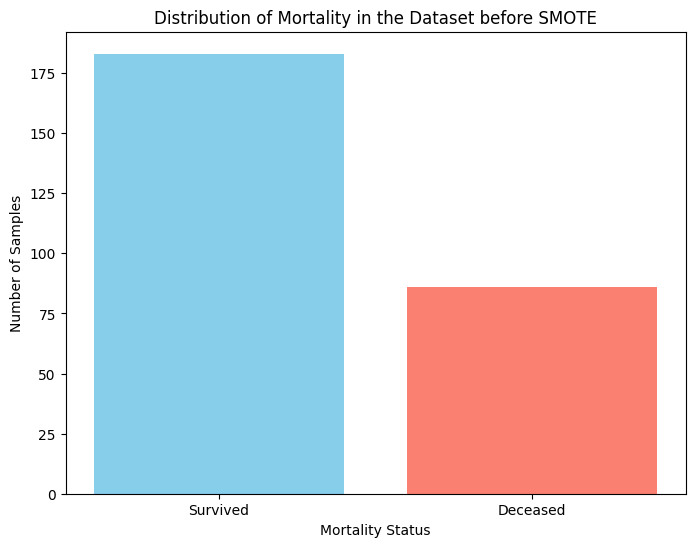

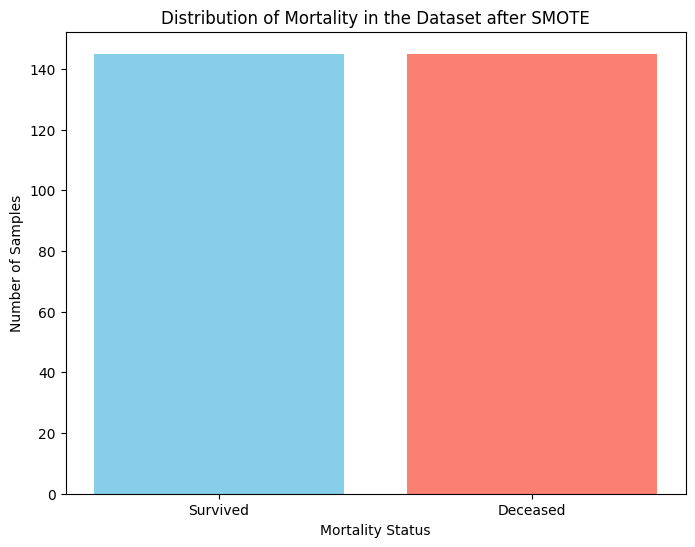

Performance of all 4-feature subsets on validation set:
Features: ('age', 'anaemia', 'creatinine_phosphokinase', 'diabetes'), AUC: 0.450
Features: ('age', 'anaemia', 'creatinine_phosphokinase', 'ejection_fraction'), AUC: 0.663
Features: ('age', 'anaemia', 'creatinine_phosphokinase', 'high_blood_pressure'), AUC: 0.517
Features: ('age', 'anaemia', 'creatinine_phosphokinase', 'platelets'), AUC: 0.552
Features: ('age', 'anaemia', 'creatinine_phosphokinase', 'serum_creatinine'), AUC: 0.817
Features: ('age', 'anaemia', 'creatinine_phosphokinase', 'serum_sodium'), AUC: 0.509
Features: ('age', 'anaemia', 'creatinine_phosphokinase', 'sex'), AUC: 0.503
Features: ('age', 'anaemia', 'creatinine_phosphokinase', 'smoking'), AUC: 0.437
Features: ('age', 'anaemia', 'creatinine_phosphokinase', 'time'), AUC: 0.868
Features: ('age', 'anaemia', 'diabetes', 'ejection_fraction'), AUC: 0.735
Features: ('age', 'anaemia', 'diabetes', 'high_blood_pressure'), AUC: 0.479
Features: ('age', 'anaemia', 'diabetes', '

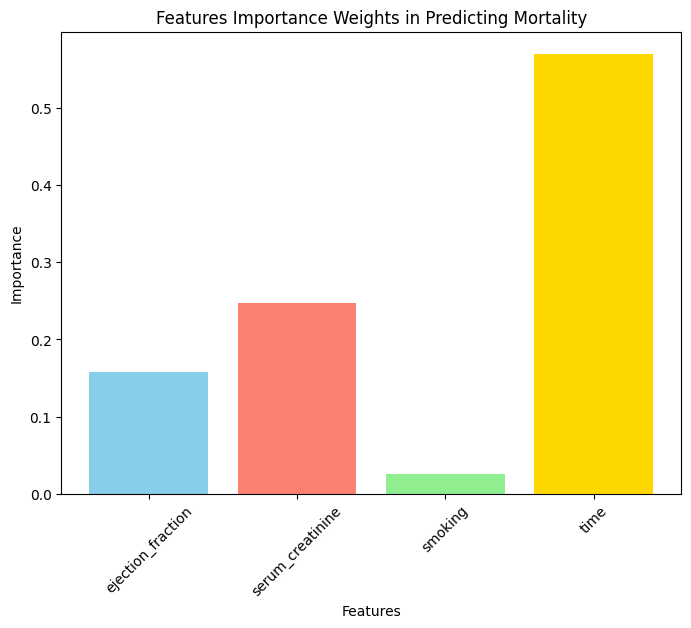


Final Performance on Test Set using Best Subset ('ejection_fraction', 'serum_creatinine', 'smoking', 'time')
Test AUC: 0.945
Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        20
           1       0.80      0.80      0.80        10

    accuracy                           0.87        30
   macro avg       0.85      0.85      0.85        30
weighted avg       0.87      0.87      0.87        30

Confusion Matrix:
 [[18  2]
 [ 2  8]]


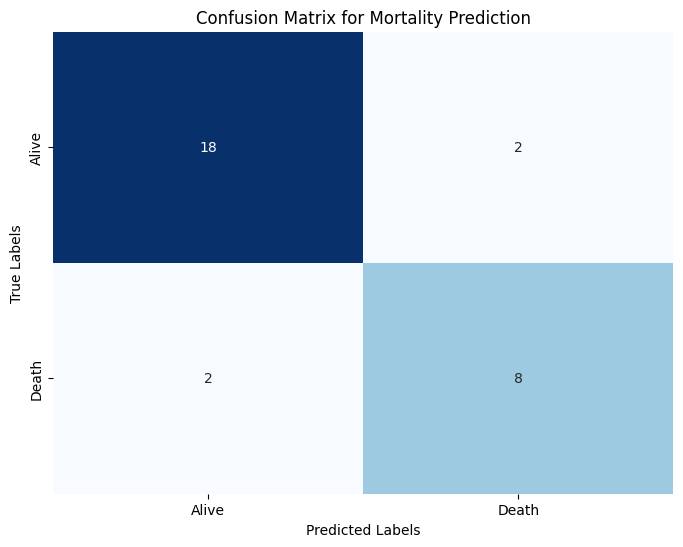


SVM Accuracy: 0.8333333333333334

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.85      0.87        20
           1       0.73      0.80      0.76        10

    accuracy                           0.83        30
   macro avg       0.81      0.82      0.82        30
weighted avg       0.84      0.83      0.84        30

SVM Confusion Matrix:
 [[17  3]
 [ 2  8]]


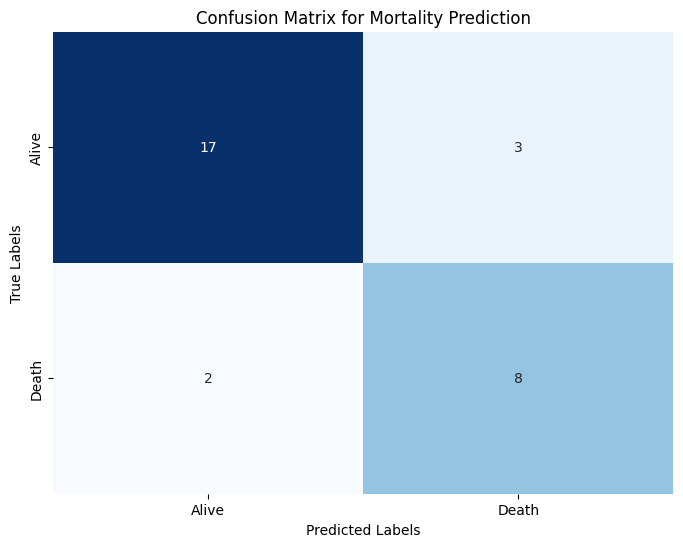


Logistic Regression Accuracy: 0.8

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        20
           1       0.75      0.60      0.67        10

    accuracy                           0.80        30
   macro avg       0.78      0.75      0.76        30
weighted avg       0.80      0.80      0.79        30

Logistic Regression Confusion Matrix:
 [[18  2]
 [ 4  6]]


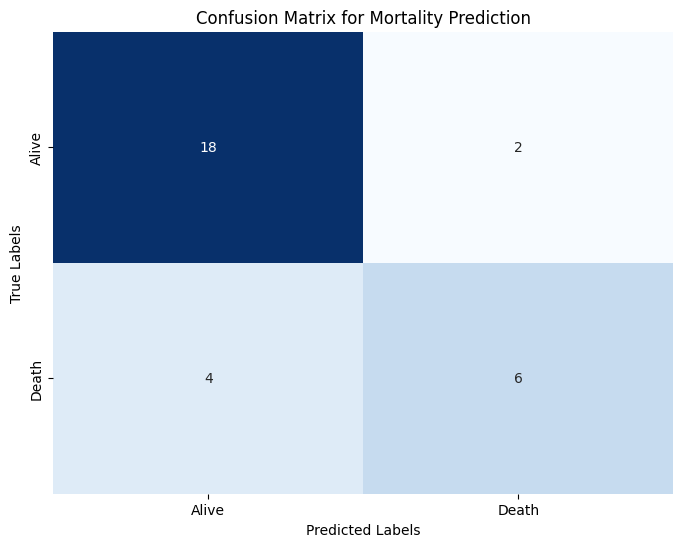

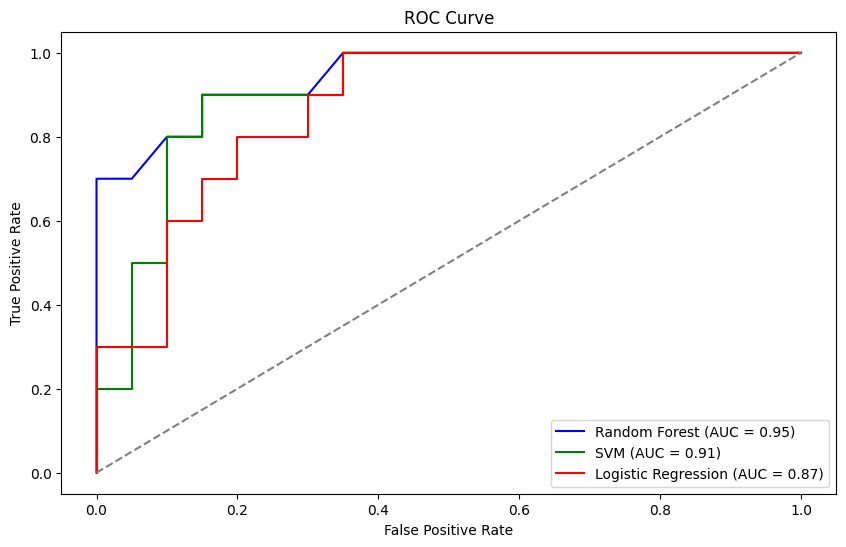

Without Smoothing nor best features selection

Final Performance on Test Set using Best Subset ('ejection_fraction', 'serum_creatinine', 'smoking', 'time')
Test AUC: 0.945
Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.83      0.95      0.88        20
           1       0.86      0.60      0.71        10

    accuracy                           0.83        30
   macro avg       0.84      0.77      0.79        30
weighted avg       0.84      0.83      0.82        30

Confusion Matrix:
 [[19  1]
 [ 4  6]]


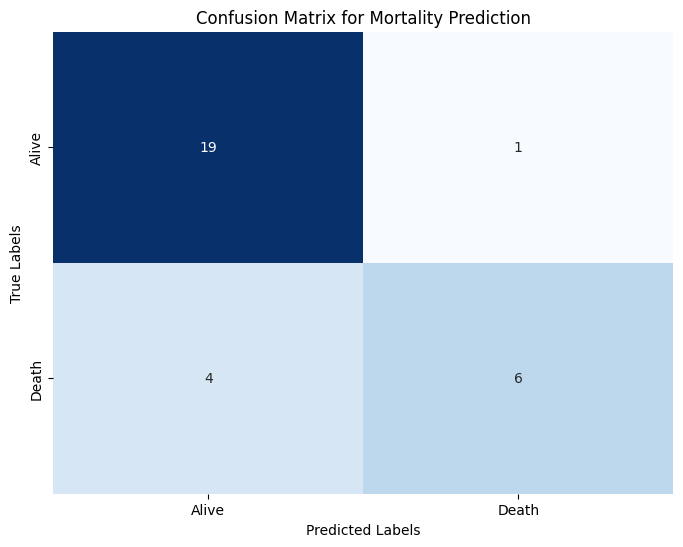


SVM Accuracy: 0.8333333333333334

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.95      0.88        20
           1       0.86      0.60      0.71        10

    accuracy                           0.83        30
   macro avg       0.84      0.77      0.79        30
weighted avg       0.84      0.83      0.82        30

SVM Confusion Matrix:
 [[19  1]
 [ 4  6]]


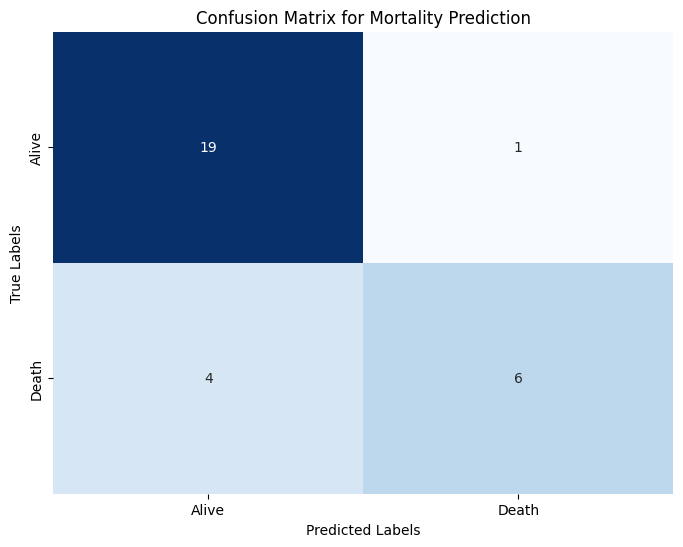


Logistic Regression Accuracy: 0.8333333333333334

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.95      0.88        20
           1       0.86      0.60      0.71        10

    accuracy                           0.83        30
   macro avg       0.84      0.77      0.79        30
weighted avg       0.84      0.83      0.82        30

Logistic Regression Confusion Matrix:
 [[19  1]
 [ 4  6]]


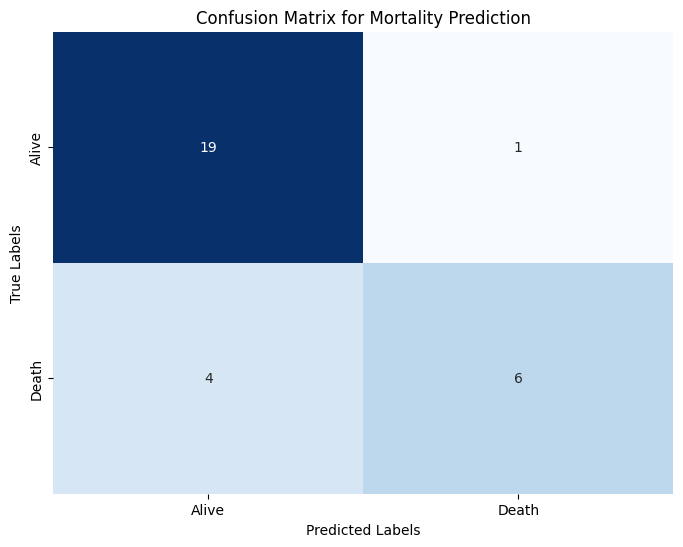

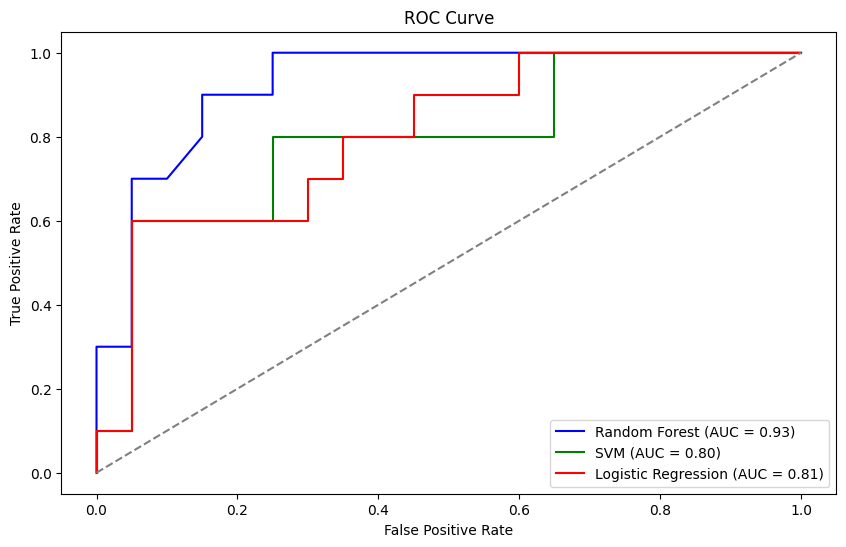

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, classification_report, confusion_matrix, ConfusionMatrixDisplay
from itertools import combinations
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Load CSV Data
data_file = 'drive/MyDrive/1AConferencesJournals/BIBM24/BiomarkerProject/heart+failure+clinical+records/heart_failure_clinical_records_dataset.csv'
data = pd.read_csv(data_file)

# Define feature matrix (X) and target vector (y)
X = data.iloc[:, :-1]  # All columns except the last one
y = data.iloc[:, -1]   # Last column as the target variable (mortality)

# Split data into training, validation, and test sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=0)  # 60% train, 20% val, 20% test


# Check the distribution of the target variable (assuming 'mortality' is binary: 1 = positive, 0 = negative)
target_counts = y_train_full.value_counts()  # Assuming last column is the target (mortality)

# Plot distribution
plt.figure(figsize=(8, 6))
plt.bar(['Survived', 'Deceased'], target_counts, color=['skyblue', 'salmon'])
plt.xlabel('Mortality Status')
plt.ylabel('Number of Samples')
plt.title('Distribution of Mortality in the Dataset before SMOTE')
plt.show()



# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=0)
X_train, y_train = smote.fit_resample(X_train, y_train)


# Plot distribution
plt.figure(figsize=(8, 6))
plt.bar(['Survived', 'Deceased'], y_train.value_counts(), color=['skyblue', 'salmon'])
plt.xlabel('Mortality Status')
plt.ylabel('Number of Samples')
plt.title('Distribution of Mortality in the Dataset after SMOTE')
plt.show()

# Standardize features for consistency across models
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Initialize lists to store results
best_subset = None
best_auc = 0
all_results = []

# Iterate through all 3-feature combinations
for subset in combinations(X.columns, 4):
    # Select the current subset of features
    X_train_subset = X_train[:, [X.columns.get_loc(feature) for feature in subset]]
    X_val_subset = X_val[:, [X.columns.get_loc(feature) for feature in subset]]

    # Train a model on this subset
    rf_model = RandomForestClassifier(random_state=0)
    rf_model.fit(X_train_subset, y_train)

    # Predict and calculate AUC on validation set
    val_probs = rf_model.predict_proba(X_val_subset)[:, 1]
    val_auc = roc_auc_score(y_val, val_probs)

    # Store results
    all_results.append((subset, val_auc))
    if val_auc > best_auc:
        best_auc = val_auc
        best_subset = subset

# Print all subset performances on validation set
print("Performance of all 4-feature subsets on validation set:")
for subset, auc in all_results:
    print(f"Features: {subset}, AUC: {auc:.3f}")

print(f"\nBest Subset: {best_subset}, Best AUC on Validation: {best_auc:.3f}")

# Apply the best subset on the test set
X_train_best = X_train[:, [X.columns.get_loc(feature) for feature in best_subset]]
X_test_best = X_test[:, [X.columns.get_loc(feature) for feature in best_subset]]

# Retrain on the best subset
best_rf_model = RandomForestClassifier(random_state=0)
best_rf_model.fit(X_train_best, y_train)
# Get feature importances
feature_importances = best_rf_model.feature_importances_
print("Features Importance:", feature_importances)

colors = ['skyblue', 'salmon', 'lightgreen', 'gold']
# Plotting the histogram
plt.figure(figsize=(8, 6))
plt.bar(best_subset, feature_importances, color=colors)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Features Importance Weights in Predicting Mortality')
plt.xticks(rotation=45)
plt.show()


# Retrain on the best subset
best_rf_model = RandomForestClassifier(random_state=0)
best_rf_model.fit(X_train_best, y_train)
test_probs = best_rf_model.predict_proba(X_test_best)[:, 1]
test_auc = roc_auc_score(y_test, test_probs)
# Print final performance on test set
print(f"\nFinal Performance on Test Set using Best Subset {best_subset}")
print(f"Test AUC: {test_auc:.3f}")
print("Classification Report on Test Set:")
print(classification_report(y_test, best_rf_model.predict(X_test_best)))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, best_rf_model.predict(X_test_best))
print("Confusion Matrix:\n", conf_matrix)
# Plot confusion matrix
# Plot confusion matrix with color annotations
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=['Alive', 'Death'], yticklabels=['Alive', 'Death'])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for Mortality Prediction")
plt.show()


# Train SVM on the scaled data
svm_model = SVC(probability=True, random_state=0)
svm_model.fit(X_train_best, y_train)
y_test_pred_svm = svm_model.predict(X_test_best)

# Evaluate SVM
svm_accuracy = accuracy_score(y_test, y_test_pred_svm)
print("\nSVM Accuracy:", svm_accuracy)
print("\nSVM Classification Report:")
print(classification_report(y_test, y_test_pred_svm))

# Calculate and print confusion matrix
conf_matrix_svm = confusion_matrix(y_test, y_test_pred_svm)
print("SVM Confusion Matrix:\n", conf_matrix_svm)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_svm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=['Alive', 'Death'], yticklabels=['Alive', 'Death'])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for Mortality Prediction")
plt.show()



#
# Fit the logistic regression model on selected features
logistic_model = LogisticRegression()
logistic_model.fit(X_train_best, y_train)
y_test_pred_log = logistic_model.predict(X_test_best)

# Evaluate SVM
svm_accuracy = accuracy_score(y_test, y_test_pred_log)
print("\nLogistic Regression Accuracy:", svm_accuracy)
print("\nLogistic Regression Classification Report:")
print(classification_report(y_test, y_test_pred_log))

# Calculate and print confusion matrix
conf_matrix_log= confusion_matrix(y_test, y_test_pred_log)
print("Logistic Regression Confusion Matrix:\n", conf_matrix_log)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_log, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=['Alive', 'Death'], yticklabels=['Alive', 'Death'])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for Mortality Prediction")
plt.show()

#RF ROC
test_probs = best_rf_model.predict_proba(X_test_best)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, test_probs)
roc_auc_rf = roc_auc_score(y_test, test_probs)
# Plot ROC curve for SVM
svm_probs = svm_model.predict_proba(X_test_best)[:, 1]
fpr_svm, tpr_svm, _ = roc_curve(y_test, svm_probs)
roc_auc_svm = roc_auc_score(y_test, svm_probs)
#Logistic regression
# Plot ROC curve for SVM
log_probs = logistic_model.predict_proba(X_test_best)[:, 1]
fpr_log, tpr_log, _ = roc_curve(y_test, log_probs)
roc_auc_log = roc_auc_score(y_test, log_probs)


# Plot both ROC curves
plt.figure(figsize=(10, 6))
plt.plot(fpr_rf, tpr_rf, color='blue', label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot(fpr_svm, tpr_svm, color='green', label=f'SVM (AUC = {roc_auc_svm:.2f})')
plt.plot(fpr_log, tpr_log, color='red', label=f'Logistic Regression (AUC = {roc_auc_log:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()



print("Without Smoothing nor best features selection")
# Split data into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)



# Standardize features for consistency across models
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



# Apply the best subset on the test set
X_train_best = X_train
X_test_best = X_test

# Retrain on the best subset
best_rf_model = RandomForestClassifier(random_state=0)
best_rf_model.fit(X_train_best, y_train)


# Print final performance on test set
print(f"\nFinal Performance on Test Set using Best Subset {best_subset}")
print(f"Test AUC: {test_auc:.3f}")
print("Classification Report on Test Set:")
print(classification_report(y_test, best_rf_model.predict(X_test_best)))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, best_rf_model.predict(X_test_best))
print("Confusion Matrix:\n", conf_matrix)
# Plot confusion matrix
# Plot confusion matrix with color annotations
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=['Alive', 'Death'], yticklabels=['Alive', 'Death'])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for Mortality Prediction")
plt.show()


# Train SVM on the scaled data
svm_model = SVC(probability=True, random_state=0)
svm_model.fit(X_train_best, y_train)
y_test_pred_svm = svm_model.predict(X_test_best)

# Evaluate SVM
svm_accuracy = accuracy_score(y_test, y_test_pred_svm)
print("\nSVM Accuracy:", svm_accuracy)
print("\nSVM Classification Report:")
print(classification_report(y_test, y_test_pred_svm))

# Calculate and print confusion matrix
conf_matrix_svm = confusion_matrix(y_test, y_test_pred_svm)
print("SVM Confusion Matrix:\n", conf_matrix_svm)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_svm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=['Alive', 'Death'], yticklabels=['Alive', 'Death'])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for Mortality Prediction")
plt.show()



#
# Fit the logistic regression model on selected features
logistic_model = LogisticRegression()
logistic_model.fit(X_train_best, y_train)
y_test_pred_log = logistic_model.predict(X_test_best)

# Evaluate SVM
svm_accuracy = accuracy_score(y_test, y_test_pred_log)
print("\nLogistic Regression Accuracy:", svm_accuracy)
print("\nLogistic Regression Classification Report:")
print(classification_report(y_test, y_test_pred_log))

# Calculate and print confusion matrix
conf_matrix_log= confusion_matrix(y_test, y_test_pred_log)
print("Logistic Regression Confusion Matrix:\n", conf_matrix_log)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_log, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=['Alive', 'Death'], yticklabels=['Alive', 'Death'])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for Mortality Prediction")
plt.show()

#RF ROC
test_probs = best_rf_model.predict_proba(X_test_best)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, test_probs)
roc_auc_rf = roc_auc_score(y_test, test_probs)
# Plot ROC curve for SVM
svm_probs = svm_model.predict_proba(X_test_best)[:, 1]
fpr_svm, tpr_svm, _ = roc_curve(y_test, svm_probs)
roc_auc_svm = roc_auc_score(y_test, svm_probs)
#Logistic regression
# Plot ROC curve for SVM
log_probs = logistic_model.predict_proba(X_test_best)[:, 1]
fpr_log, tpr_log, _ = roc_curve(y_test, log_probs)
roc_auc_log = roc_auc_score(y_test, log_probs)


# Plot both ROC curves
plt.figure(figsize=(10, 6))
plt.plot(fpr_rf, tpr_rf, color='blue', label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot(fpr_svm, tpr_svm, color='green', label=f'SVM (AUC = {roc_auc_svm:.2f})')
plt.plot(fpr_log, tpr_log, color='red', label=f'Logistic Regression (AUC = {roc_auc_log:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()




# Get weights (coefficients)
#feature_weights = model.coef_
#print("Feature weights:", feature_weights)